## Data Cleaning

In [3]:
import pandas as pd
import sqlite3
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt  
from matplotlib.ticker import FuncFormatter
from sklearn import preprocessing

### The Movie Data Base

In [4]:
# read data in
tmdb = pd.read_csv('../Data/tmdb.movies.csv', index_col=0)
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [5]:
tmdb.shape

(26517, 9)

In [6]:
tmdb.isna().any()

genre_ids            False
id                   False
original_language    False
original_title       False
popularity           False
release_date         False
title                False
vote_average         False
vote_count           False
dtype: bool

In [7]:
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB


Here we can see that our release date isn't being treated as a datetime object. The genre IDs will also be more useful as lists rather than strings

In [8]:
# change release date to datetime
tmdb.release_date = pd.to_datetime(tmdb.release_date)
# turn genre ids into lists
tmdb.genre_ids = tmdb.genre_ids.str.strip('[]').str.split(',')
# remove whitespace from genre ids
tmdb.genre_ids = tmdb.genre_ids.apply(lambda x: [y.strip() for y in x])
# add release month column
tmdb['release_month'] = tmdb.release_date.dt.month
tmdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          26517 non-null  object        
 1   id                 26517 non-null  int64         
 2   original_language  26517 non-null  object        
 3   original_title     26517 non-null  object        
 4   popularity         26517 non-null  float64       
 5   release_date       26517 non-null  datetime64[ns]
 6   title              26517 non-null  object        
 7   vote_average       26517 non-null  float64       
 8   vote_count         26517 non-null  int64         
 9   release_month      26517 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 2.2+ MB


In [9]:
ids = []
genre_ids = []
vote_averages = []
 
popularity_by_genre = {'id': ids, 'genre_ids': genre_ids, 'vote_average': vote_averages}
 
for index, row in tmdb.iterrows():
    for genre in row[0]:
        ids.append(row[1])
        genre_ids.append(genre)
        vote_averages.append(row[7])
 
popularity_by_genre = pd.DataFrame(popularity_by_genre)
popularity_by_genre

,id,genre_ids,vote_average
0,12444,12,7.7
1,12444,14,7.7
2,12444,10751,7.7
3,10191,14,7.7
4,10191,12,7.7
...,...,...,...
47829,366854,10751,0.0
47830,366854,12,0.0
47831,366854,28,0.0
47832,309885,53,0.0


In [10]:
# get unique set of genres
genres = set(tmdb.genre_ids.sum())

# convert genre ids list back to string
tmdb.genre_ids = tmdb.genre_ids.astype(str)

# check if string contains the genre
for genre in genres:
    tmdb[genre] = tmdb.genre_ids.str.contains(genre)

In [11]:
# rename columns for genres
genre_mappings = {
    '28': 'Action',
    '12': 'Adventure',
    '16': 'Animation',
    '35': 'Comedy',
    '80': 'Crime',
    '99': 'Documentary',
    '18': 'Drama',
    '10751': 'Family',
    '14': 'Fantasy',
    '36': 'History',
    '27': 'Horror',
    '10402': 'Music',
    '9648': 'Mystery',
    '10749': 'Romance',
    '878': 'Science Fiction',
    '10770': 'TV Movie',
    '53': 'Thriller',
    '10752': 'War',
    '37': 'Western'
}

tmdb = tmdb.rename(columns=genre_mappings)
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,...,Adventure,Romance,War,History,Action,Family,Horror,Crime,Animation,Thriller
0,"['12', '14', '10751']",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,11,...,True,False,False,False,False,True,False,False,False,False
1,"['14', '12', '16', '10751']",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,3,...,True,False,False,False,False,True,False,False,True,False
2,"['12', '28', '878']",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,5,...,True,False,False,False,True,False,False,False,False,False
3,"['16', '35', '10751']",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,11,...,False,False,False,False,False,True,False,False,True,False
4,"['28', '878', '12']",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,7,...,True,False,False,False,True,False,False,False,False,False


In [12]:
tmdb.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,...,Adventure,Romance,War,History,Action,Family,Horror,Crime,Animation,Thriller
0,"['12', '14', '10751']",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788,11,...,True,False,False,False,False,True,False,False,False,False
1,"['14', '12', '16', '10751']",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,3,...,True,False,False,False,False,True,False,False,True,False
2,"['12', '28', '878']",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,5,...,True,False,False,False,True,False,False,False,False,False
3,"['16', '35', '10751']",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174,11,...,False,False,False,False,False,True,False,False,True,False
4,"['28', '878', '12']",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,7,...,True,False,False,False,True,False,False,False,False,False


In [13]:
tmdb.describe()

,id,popularity,vote_average,vote_count,release_month
count,26517.000000,26517.000000,26517.000000,26517.000000,26517.000000
mean,295050.153260,3.130912,5.991281,194.224837,6.405966
std,153661.615648,4.355229,1.852946,960.961095,3.573796
min,27.000000,0.600000,0.000000,1.000000,1.000000
25%,157851.000000,0.600000,5.000000,2.000000,3.000000
50%,309581.000000,1.374000,6.000000,5.000000,6.000000
75%,419542.000000,3.694000,7.000000,28.000000,10.000000
max,608444.000000,80.773000,10.000000,22186.000000,12.000000


Here we can see that many of the movies have very few votes under vote count which may influence the overall rating for that movie. We should make sure that there are a reasonable amount of votes before continuing with our analysis

In [14]:
# remove rows where there are fewer than 28 votes
tmdb_final = tmdb.query('vote_count >= 100').copy()
print(tmdb_final.shape)
tmdb_final.describe()

(3686, 30)


,id,popularity,vote_average,vote_count,release_month
count,3686.000000,3686.000000,3686.000000,3686.000000,3686.000000
mean,223283.718394,11.281023,6.389392,1325.535269,6.974498
std,144382.238450,6.196958,0.862305,2270.643058,3.449799
min,27.000000,0.600000,2.000000,100.000000,1.000000
25%,78090.500000,7.557750,5.800000,186.000000,4.000000
50%,234102.000000,9.395000,6.400000,422.000000,7.000000
75%,339966.250000,12.894000,7.000000,1306.000000,10.000000
max,569547.000000,80.773000,8.600000,22186.000000,12.000000


### Movie Budgets

In [15]:
movie_budgets = pd.read_csv('../Data/tn.movie_budgets.csv')
print(movie_budgets.shape)
movie_budgets.head()

(5782, 6)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [16]:
movie_budgets.isna().any()

id                   False
release_date         False
movie                False
production_budget    False
domestic_gross       False
worldwide_gross      False
dtype: bool

In [17]:
movie_budgets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [18]:
movie_budgets['production_budget'] = (movie_budgets['production_budget']
                                      .str.replace(',', '')
                                      .str.replace('$', '')
                                      .astype(float))

movie_budgets['domestic_gross'] = (movie_budgets['domestic_gross']
                                   .str.replace(',', '')
                                   .str.replace('$', '')
                                   .astype(float))

movie_budgets['worldwide_gross'] = (movie_budgets['worldwide_gross']
                                    .str.replace(',', '')
                                    .str.replace('$', '')
                                    .astype(float))

In [19]:
movie_budgets['release_date'] = pd.to_datetime(movie_budgets['release_date'])

### Combined TMDB and Budgets

In [20]:
tmdb_with_budgets = pd.merge(tmdb_final, movie_budgets,  how='inner', left_on=['title','release_date'], right_on = ['movie','release_date'])

In [21]:
tmdb_with_budgets['income'] = tmdb_with_budgets.domestic_gross + tmdb_with_budgets.worldwide_gross - tmdb_with_budgets.production_budget

In [22]:
tmdb_with_budgets.sort_values('income', ascending=False)

,genre_ids,id_x,original_language,original_title,popularity,release_date,title,vote_average,vote_count,release_month,...,Horror,Crime,Animation,Thriller,id_y,movie,production_budget,domestic_gross,worldwide_gross,income
5,"['28', '12', '14', '878']",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676,12,...,False,False,False,False,1,Avatar,425000000.0,760507625.0,2.776345e+09,3.111853e+09
1135,"['12', '28', '14']",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948,4,...,False,False,False,False,7,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,2.426950e+09
661,"['28', '12', '878', '53']",135397,en,Jurassic World,20.709,2015-06-12,Jurassic World,6.6,14056,6,...,False,False,False,True,34,Jurassic World,215000000.0,652270625.0,1.648855e+09,2.086125e+09
257,"['878', '28', '12']",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673,5,...,False,False,False,False,27,The Avengers,225000000.0,623279547.0,1.517936e+09,1.916215e+09
1138,"['28', '12', '14', '878']",284054,en,Black Panther,44.140,2018-02-16,Black Panther,7.4,12365,2,...,False,False,False,False,42,Black Panther,200000000.0,700059566.0,1.348258e+09,1.848318e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
687,"['80', '53', '28']",201088,en,Blackhat,16.824,2015-01-16,Blackhat,5.3,1165,1,...,False,True,False,True,47,Blackhat,70000000.0,8005980.0,1.966500e+07,-4.232902e+07
743,"['35', '37']",347969,en,The Ridiculous 6,10.187,2015-12-11,The Ridiculous 6,5.0,676,12,...,False,False,False,False,52,The Ridiculous 6,60000000.0,0.0,0.000000e+00,-6.000000e+07
935,"['36', '10749', '18']",354859,en,The Promise,10.158,2017-04-21,The Promise,7.1,195,4,...,False,False,False,False,78,The Promise,90000000.0,8224288.0,1.055142e+07,-7.122430e+07
934,"['36', '10749', '18']",354859,en,The Promise,10.158,2017-04-21,The Promise,7.1,195,4,...,False,False,False,False,78,The Promise,90000000.0,8224288.0,1.055142e+07,-7.122430e+07


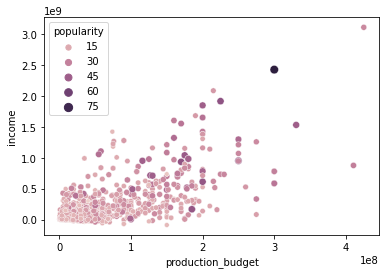

In [23]:
sns.scatterplot(data=tmdb_with_budgets, x='production_budget', y='income', size='popularity', hue='popularity');

Here we can see there appears to be a slight positive correlation between production budget and our income value. This isn't very surprising considering that movies with greater budgets are probably likely to generate greater revenue

In [24]:
genres_with_budgets = popularity_by_genre.merge(tmdb_with_budgets, how='inner', left_on='id', right_on='id_x')
columns = ['genre_ids_x',
           'vote_average_x',
           'popularity',
           'vote_count',
           'production_budget',
           'domestic_gross',
           'worldwide_gross',
           'income']
genres_with_budgets = genres_with_budgets[columns]
genres_with_budgets = genres_with_budgets.rename({'genre_ids_x': 'genre_id', 'vote_average_x': 'vote_average'}, axis=1)
genres_with_budgets.head()

,genre_id,vote_average,popularity,vote_count,production_budget,domestic_gross,worldwide_gross,income
0,14,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,547452224.0
1,12,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,547452224.0
2,16,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,547452224.0
3,10751,7.7,28.734,7610,165000000.0,217581232.0,494870992.0,547452224.0
4,12,6.8,28.515,12368,170000000.0,312433331.0,621156389.0,763589720.0


In [25]:
genres_with_budgets.genre_id = genres_with_budgets.genre_id.map(genre_mappings)
genre_averages = genres_with_budgets.groupby('genre_id').mean().sort_values('income', ascending=False)
genre_averages

,vote_average,popularity,vote_count,production_budget,domestic_gross,worldwide_gross,income
genre_id,,,,,,,
Animation,6.750442,16.719522,3545.504425,9.800885e+07,1.427478e+08,3.871088e+08,4.318478e+08
Adventure,6.538438,19.855206,4813.768750,1.168847e+08,1.421237e+08,4.040579e+08,4.292969e+08
Fantasy,6.412637,19.635352,4329.626374,1.061277e+08,1.303736e+08,3.668990e+08,3.911448e+08
Family,6.620339,16.123921,3226.378531,9.218870e+07,1.296079e+08,3.406241e+08,3.780433e+08
Science Fiction,6.415657,19.584525,5145.328283,9.829205e+07,1.197484e+08,3.278761e+08,3.493324e+08
Action,6.371744,19.101835,3973.958231,9.231253e+07,1.066569e+08,2.954076e+08,3.097520e+08
War,6.842500,15.528800,2906.000000,4.989000e+07,8.165585e+07,1.624851e+08,1.942510e+08
Comedy,6.390349,13.339242,2166.946612,4.501057e+07,7.095921e+07,1.661822e+08,1.921308e+08
Western,6.750000,15.274909,4910.181818,6.029545e+07,6.716700e+07,1.717377e+08,1.786092e+08


This is a quick breakdown of our average key values grouped by genre

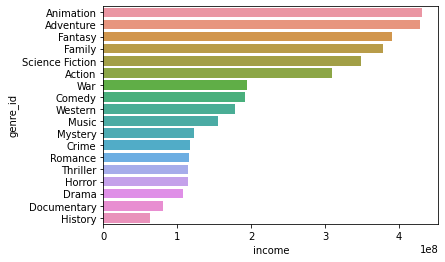

In [26]:
sns.barplot(data=genre_averages, x='income' , y=genre_averages.index);

This is a heatmap that breaks down each genre to show profit at each rating, in billions. This is visualizing how some genres are only really profitable if reception is majorly positive, some genres are profitable consistently over a larger variety of ratings, and some genres simply are not profitable regardless of ratings.

In [174]:
# Converts income to be read in billions and rounds to 1 decimal place
genres_with_budgets['incomebillions'] = round(genres_with_budgets['income']/1000000000, 1)

# As a precaution for any variance, rounds all vote rating to 1 decimal place
genres_with_budgets['int_vote_avg'] = round(genres_with_budgets['vote_average'], 1)

# Sets a filter on the vote average to range between 5.7 and 8.3, due to all values beneath 5.7 yielding similar results to values less than 6, and no data existing for ratings higher than 8.3
genres_with_budgets = genres_with_budgets[(genres_with_budgets['int_vote_avg']>=5.7) & (genres_with_budgets['int_vote_avg']<=8.3)]

# Generates a new table with only the above values for use in the heatmap below
heatmap_df = pd.pivot_table(genres_with_budgets, index='genre_id', columns='int_vote_avg', values='incomebillions')
heatmap_df = heatmap_df.fillna(0)

<ipython-input-176-11ee22e903bb>:33: MatplotlibDeprecationWarning: 
The config_axis function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  cbar.config_axis()


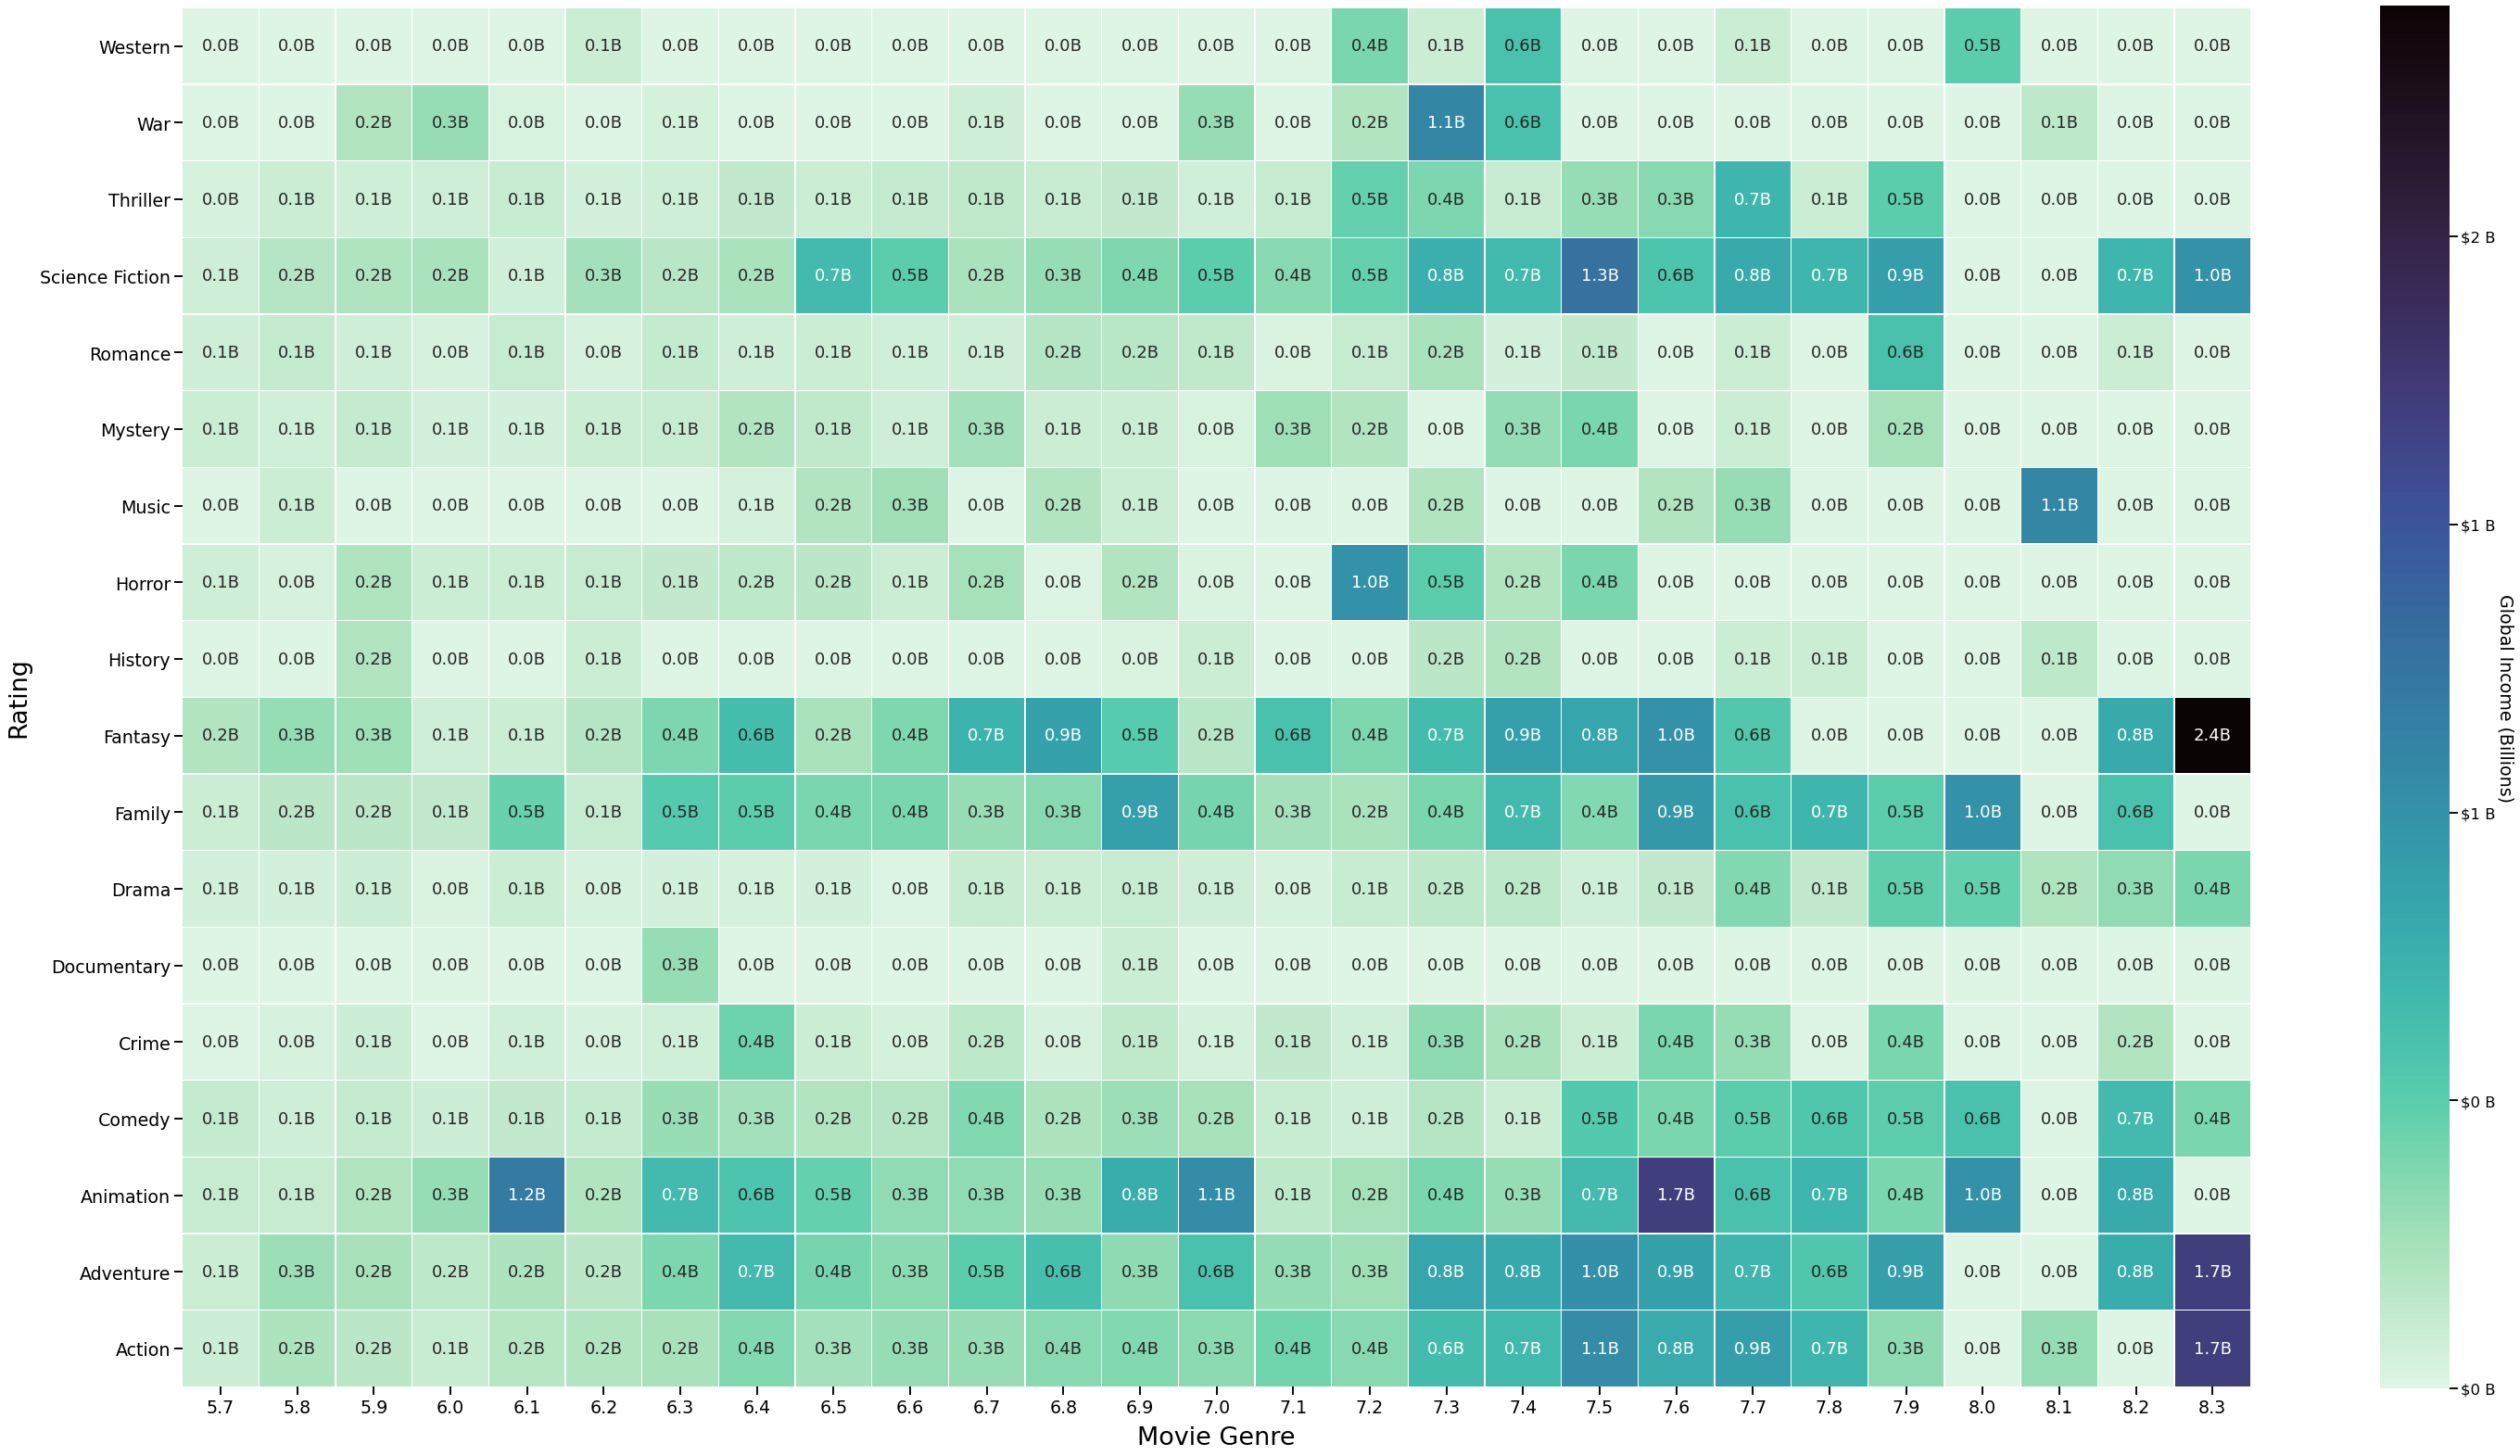

In [176]:
# Creates size and subplot for the heatmap figure
fig = plt.figure(figsize=(50,70))
ax = fig.add_subplot(1,1,1)

# Automatically adds text to the color bar values on the right
comma_fmt = FuncFormatter(lambda x, p: format("$" + str(int(x)) + " B"))

# Improves readability on smaller computers
sns.set_context("talk")

# Generates a heatmap with proper theme, linewidth, annotation, and cbar formatting. Sets the heatmap to a variable for future reference
ax = sns.heatmap(heatmap_df, linewidth=0.2, annot=True, cmap='mako_r',
                 fmt=',.1f', square=True, annot_kws={'size': 18},
                 cbar_kws={'format': comma_fmt, 'orientation':'vertical', 'shrink':.392})

# Adds a 'B' to the end of each value in each square of the heatmap to indicate the number measures in billions
for t in ax.texts:
    t.set_text(t.get_text() + "B")

# Sets labels for x-axis, y-axis, and the title of the chart
plt.title("HeatMap of Global Revenue by Rating and Genre", fontsize=30, pad=15)
plt.xlabel("Movie Genre", fontsize=27, labelpad=10)
plt.ylabel("Rating", fontsize=27, labelpad=10)
plt.yticks(rotation=0, fontsize=19)
plt.xticks(size=19)

# Flips the y-axis to align values accurately
ax.invert_yaxis()

# Creates a colorbar, labels it, and formats it
cbar = ax.collections[0].colorbar
cbar.set_label("Global Income (Billions)", rotation=270, fontsize=19, color='black', labelpad=20)
cbar.config_axis()

plt.show()